Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE"

Do not edit or insert code into the test cells as all you insert will be overwritten by the automated testing code.

---

**Question 8**: Full radiation sensor experiment simulation - set up a fairly complete radiation sensor simulation and analysis code.

**(a)**: Use the simple pulse model function from the script (page 43, function `simple_pulse`, lines 4-10) and modify it to take the full time value array as first input as well as the pulse onset number as second input parameter: `simple_pulse(time, onset, amplitude, risetime, decaytime)`.

**(b)**: Create a set of 2000 pulses of length 1000, i.e. a 2D array of shape (2000,1000), with each column entry corresponding to 1 ns sampling (and each row is a pulse) with the following composition: 

- A fraction of 45% of all pulses should feature amplitudes, $A$, from a uniform distribution between 1 and 100. Each pulse should have a risetime of 6 ns, decay time of 200 ns and onset time of 250 ns. Then, separately, add noise to each pulse. The noise should consist of 1000 Gaussian random numbers with amplitude of $\sqrt{A}$, added to the 1000 pulse values. Store the pulses for processing at the next stage.

- Another 45% of all pulses should be randomly chosen from a set of amplitudes: $(11, 16, 31, 82)$, representing constant energy radiation (hence constant amplitude) from a source. Again, add Gaussian noise to each pulse like above and add each pulse to the data store.

- The final 10% of all pulses should be made up of random amplitude, $A$, (between 1 and 20) damped oscillations with frequency $f=1/80$ ns$^{-1}$ and decay time $\tau=500$ ns, i.e. not the simple pulse model. Write a suitable function for this oscillation model: $$S(t)=A\,\sin(2\,\pi\,f\,t)\;\exp\left(\frac{-t}{\tau}\right).$$ Call this function `oscillation(length, amplitude, freq, decaytime)` with the time array length, the amplitude value, frequency and decay time values as arguments in that order. This is background data; has nothing to do with pulses! These oscillations would represent typical microphonics noise of sensors and are often a nuisance in real measurements. Again, add Gaussian noise to each oscillation model like above and add each output to the data store.

**(c)**: Fit all pulses in the data store and store the fitted amplitudes and, separately, the relative errors of all 4 fitted parameters. The latter should result in a 2D array of shape $(N,4)$ with $N$ the number of successfully fitted pulses, see hint below. Complicated fits really require good **starting value guesses** and **fit parameter boundaries**, both of which can be handed over to the scipy `curve_fit()` function. 

**Hint**: Remember that fits can fail and should then simply be discarded. Recent improvements to SciPy resulted in no failed fits hence you may or may not get a few, resulting in $N<2000$.

**Hint2**: You need to fit the pulse model, not the oscillation model! You look for pulses in the entire data set. Expect the data representing oscillations not fitting well to the pulse model. That is the point of nuisance data.

**(d)**: Draw a **first** plot of amplitudes against onset relative error, with appropriate axis labels, and define a selection cut (likely on too small amplitudes) for a population of fit results which should represent well-fit, reliable pulse amplitudes. A selection cut is a conditional statement, most easily done with NumPy arrays since that allows smart slicing, i.e. the application of the cut on the array of fit results.
Feel free to plot other fit values or fit errors against each other. The combination stated above worked fine for the model solution. Note that extreme values (extremely large or small) result from bad fits and should be discarded as they distort the plot.

**(e)** Draw as a **second** figure a histogram plot of this select population of amplitudes. This histogram should show amplitude peaks corresponding to the simulated radiation source (the four fixed amplitudes from above) and some background.

**(f)**: Fit and draw (on the histogram) the radiation peaks with Gaussian, best-fit curves. You may fit and plot each Gaussian individually or as a combined model with background, as you wish (same marks). Create a **final, third** plot of fitted peak width against fitted peak position for the fitted Gaussians. This represents the energy resolution response function of your hypothetical radiation sensor.


C:\Users\tytki\AppData\Local\Temp\ipykernel_9724\3344629174.py:21: RuntimeWarning: overflow encountered in exp
  pulse = np.exp( - (time - onset) / risetime) - np.exp( - (time - onset) / decaytime)


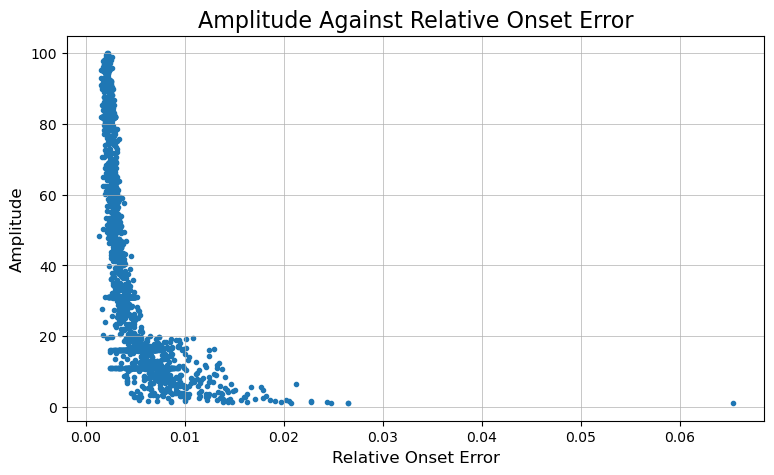

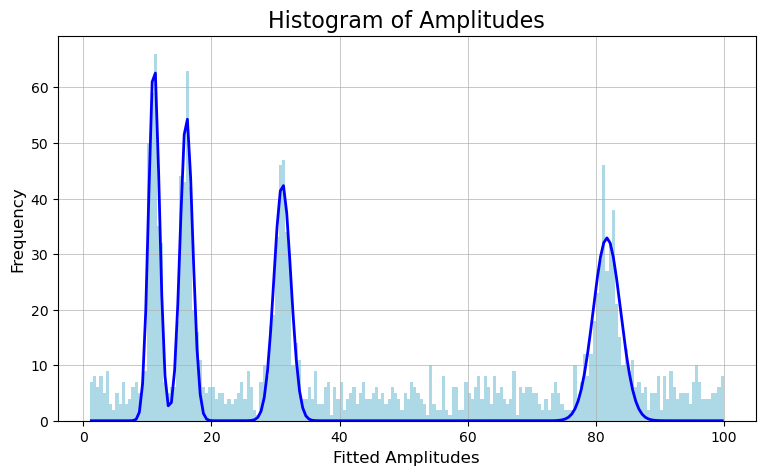

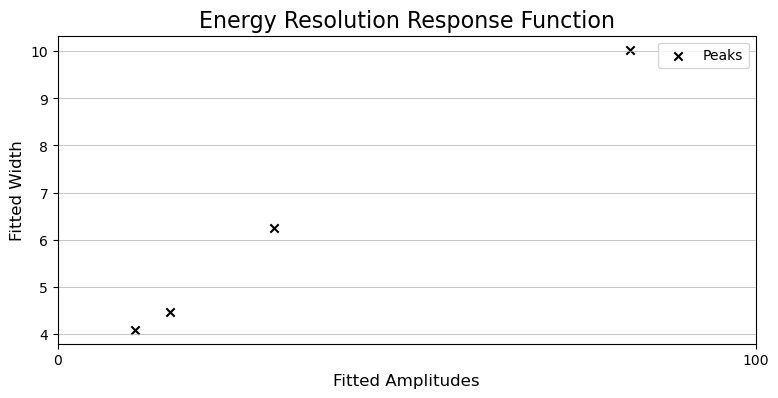

In [1]:
# YOUR CODE HERE
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.optimize import curve_fit

# Initialising parameters
onset = 250.0
rt = 6.0
dt = 200.0
l = 1000
t = np.linspace(0, l - 1, l)
Npul = 2000
q1 = int(Npul * 0.45)
q2 = int(Npul * 0.9)

# (a) Creating the simple pulse function
def simple_pulse(time, onset, amplitude, risetime, decaytime):
    pulse = np.exp( - (time - onset) / risetime) - np.exp( - (time - onset) / decaytime)
    pulse[np.where(time < onset)] = 0.0
    return - amplitude * pulse

# (b) Creating the require (2000, 1000) sized array
pulsim = np.zeros(shape = (2000, 1000)) # initialise the array
amp_array = []

# values for the first 45%
for i in range(0, q1):
    amp =  np.random.uniform(1,100)
    amp_array.append(amp)
    pulsim[i] = simple_pulse(t, onset, amp, rt, dt)
    noise = np.sqrt(amp) * np.random.normal(size = 1000)
    pulsim[i] += noise

# values for the second 45%
for i in range(q1, q2):
    amp = np.random.choice([11, 16, 31, 82])
    amp_array.append(amp)
    pulsim[i] = simple_pulse(t, onset, amp, rt, dt)
    noise = np.sqrt(amp) * np.random.normal(size = 1000)
    pulsim[i] += noise

# defining oscillation function
def oscillation(length, amplitude, freq, decaytime):
    t = np.linspace(0, length - 1, length)
    st = amplitude * np.sin(2 * np.pi * freq * t) * np.exp( - t / decaytime)
    return st

# values for the last 10%
for i in range(q2, Npul):
    amp = np.random.uniform(low = 1, high = 20)
    amp_array.append(amp)
    pulsim[i] = oscillation(l, amp, 1.0 / 80.0, 500.0)
    noise = np.sqrt(amp) * np.random.normal(size = 1000)
    pulsim[i] += noise

# (c) Fitting data
fitted_amps = []
error_array = []
delete_array = []

for i in range (Npul):
    try:
        fitpul, cov = curve_fit(simple_pulse, t, pulsim[i], p0 = [onset,amp_array[i],
                                rt, dt], bounds = ([220,1,2,0], [280,101,12,300]))
        fitted_amps.append(fitpul[1])
        std = np.sqrt(np.diag(cov))
        error_array.append([std[0] / fitpul[0], std[1] / fitpul[1],
                            std[2] / fitpul[2], std[3] / fitpul[3]])
    except(RuntimeError, ValueError):
        delete_array.append(i)
        # failed fit
        fitpul = None
        
for i in delete_array:
    amp_array.pop(i)
    fitted_amps.pop(i)

# (d) Plotting values from (c)
error_array = np.array(error_array)
plt.figure(figsize = (9, 5))
plt.scatter(error_array[:,0], amp_array, marker = ".")
plt.title("Amplitude Against Relative Onset Error", fontsize = 16)
plt.ylabel("Amplitude", fontsize = 12)
plt.xlabel("Relative Onset Error", fontsize = 12)
plt.grid(linewidth = 0.5)
plt.show()

# (e) & (f) Second Plot with Best Fit Guassian Curves
# Gaussian Plots
def gauss(x, mu, sigma, A):
    ret = A * np.exp( - (x - mu) ** 2 / 2 / sigma ** 2)
    return ret

plt.figure(figsize = (9, 5))
vals, bins, _ = plt.hist(fitted_amps, bins = 198, range = (1,100), color = (0.678, 0.848, 0.899))
# Getting the middle of each bin.
bins = (bins[1: ] + bins[: -1]) / 2

# combined curves function to curve_fit
def combined_curves(x, m1, s1, A1, m2, s2, A2, m3, s3, A3, m4, s4, A4):
    curve1 = gauss(x, m1, s1, A1)
    curve2 = gauss(x, m2, s2, A2)
    curve3 = gauss(x, m3, s3, A3)
    curve4 = gauss(x, m4, s4, A4)
    return curve1 + curve2 + curve3 + curve4

# using curve_fit to find appropriate parameters
p0 = (11, 0.5, 90, 16, 0.5, 85, 31, 0.75, 70, 82, 1, 50)
fitparam, covgauss = curve_fit(combined_curves, bins, vals, p0 = p0)
fitted_gauss = combined_curves(bins, *fitparam)
plt.plot(bins, fitted_gauss, lw = 2, color = "blue", label = "Best-fit Curves")
plt.title("Histogram of Amplitudes", fontsize = 16)
plt.xlabel("Fitted Amplitudes", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.grid(linewidth = 0.5)
plt.show()

# (f) Final Plot
plt.figure(figsize = (9, 4))
peaks, _ = find_peaks(fitted_gauss, height = 20)
peakwidths = peak_widths(fitted_gauss, peaks)
plt.title("Energy Resolution Response Function", fontsize = 16)
plt.scatter((11, 16, 31, 82), peakwidths[0], marker = "x", color = "black", label = "Peaks")
plt.xlabel("Fitted Amplitudes", fontsize = 12)
plt.ylabel("Fitted Width", fontsize = 12)
plt.xticks((0, 100))
plt.legend()
plt.grid(linewidth = 0.5)
plt.show()


In [2]:
# Test cell
# test oscillation function
l = 1000
oscdecay = 500
oscfreq = 1.0/80.0
amp = 10
data = oscillation(l, amp, oscfreq, oscdecay)
assert (np.argmax(data)==20 and np.argmin(data)==60), 'wrong max and min locations.'
assert (np.max(data)>9.5 and np.max(data)<9.7), 'wrong maximum amplitude for oscillation.'


### Tests 3 marks; Style 1 mark; Plots - 8 marks

In [3]:
# Test cell
# test simple_pulse function
import numpy as np
rt = 6.0
dt = 200.0
l = 1000
amp = 10.0
t = np.linspace(0, l - 1, l)
on = 0.25 * l # start 25% into the length

data = simple_pulse(t, on, amp, rt, dt)
assert (np.argmax(data)==272), 'wrong location of pulse maximum.'
